In [2]:
#Loading packages
from __future__ import print_function 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import twopoint
from profiley.nfw import TNFW, NFW
import scipy.stats as stats
from colossus.cosmology import cosmology
cosmo = cosmology.setCosmology('planck15');
from astropy.cosmology import Planck15
from astropy import constants as const
import twopoint
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

In [6]:
#Loading measurements
theta, xi, error, cross_term = np.loadtxt('/lsbg_des/data/gt_LSBG_combined_sources_scales_3_ran', unpack=True)
theta, xi, err_jk, cross_term = np.loadtxt('/lsbg_des/data/gt_LSBG_jackknife_combined_sources_scales_3_ran', unpack=True)
theta_red, xi_red, error_red, cross_term_red = np.loadtxt('/lsbg_des/data/gt_LSBG_combined_sources_scales_3_red_ran', unpack=True)
theta_red, xi_red, err_jk_red, cross_term_red = np.loadtxt('/lsbg_des/data/gt_LSBG_jackknife_combined_sources_scales_3_red_ran', unpack=True)
theta_blue, xi_blue, error_blue, cross_term_blue = np.loadtxt('/lsbg_des/data/gt_LSBG_combined_sources_scales_3_blue_ran', unpack=True)
theta_blue, xi_blue, err_jk_blue, cross_term_blue = np.loadtxt('/lsbg_des/data/gt_LSBG_jackknife_combined_sources_scales_3_blue_ran', unpack=True)
#Defining covariance
cov = np.loadtxt('/lsbg_des/data/jkcov_gt_LSBG_combined_sources_scales_3_red_ran')
#cov = (np.diag(err_jk_red))**2


In [7]:
#Shear function for a single NFW profile
def gt(zl, mass, concentration, zs, theta_rad):
    da = Planck15.angular_diameter_distance(zl)
    r_mpc = da*theta_rad
    nfw = NFW(mass, concentration, zl)
    sigma_crit = nfw.sigma_crit([zs])
    rho = nfw.profile(r_mpc)
    esd = nfw.projected_excess(r_mpc)
    gt = esd/sigma_crit
    return gt

In [8]:
#Function to compare two different models to the measurements
def plot_model(model_1, model_2, label_model_1, label_model_2):
    fig, ax = plt.subplots(figsize=(7,5), ncols=1)
    plt.errorbar(theta, xi, err_jk, fmt="o", color="black", label="All Galaxies")
    plt.errorbar(theta_red, xi_red, err_jk_red, fmt="o", color="firebrick", label="Red Galaxies")
    plt.errorbar(theta_blue, xi_blue, err_jk_blue, fmt="o", color="royalblue", label="Blue Galaxies")
    ax.set_ylabel(r'$\Sigma(R)$ (M$_\odot$/Mpc$^2$)', fontsize=16)
    ax.plot(theta, model_1, label = str(label_model_1))
    ax.plot(theta, model_2, label = str(label_model_2))
    ax.set_ylabel(r'$\gamma_t(R)$', fontsize=16)
    ax.legend(frameon=False)
    ax.set_xlabel('$\\theta$ (arcmin)', fontsize=16)
    ax.set_xscale('log')
    ax.set_yscale('log')

In [9]:
#Chi2 function (quantitative comparison between model and measurements)
def chi2(cov, model, measurements):
    invcov = np.abs(np.linalg.inv(cov))
    chi2 = np.dot((measurements-model).T, np.dot(invcov, (measurements-model)))
    return chi2


In [10]:
#Delta chi2 function (comparison between two models)
def deltachi2(err_jk, model, measurements):
    invcov = np.abs(np.linalg.inv((np.diag(err_jk))**2))
    INVCOV = np.matrix(invcov)
    diff = np.matrix((model).T[0]-(measurements).T[0])
    deltachi2 = diff*INVCOV*diff.T
    return deltachi2

0.6297101017079711


/Users/nathaliechicoine/opt/anaconda3/lib/python3.9/site-packages/fontTools/misc/py23.py:11: DeprecationWarning: The py23 module has been deprecated and will be removed in a future release. Please update your code.
  warnings.warn(


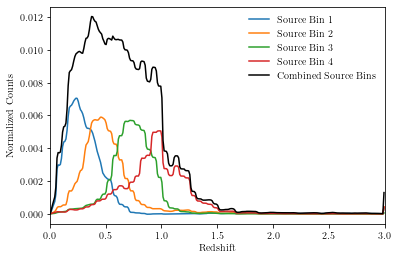

In [12]:
#Finding mean source redshift 
T = twopoint.TwoPointFile.from_fits('/lsbg_des/data/2pt_NG_final_2ptunblind_02_24_21_wnz_redmagic_covupdate.fits') #Loading source redshift file
T.kernels[0].name
nzs = (T.kernels[0].nzs) 
zsbin = (T.kernels[0].z)

#Weighting each of the source redshift bins by the galaxy count
nzs_count = 24940465+25280405+24891859+25091297 #galaxy count for bins 1-4
b1_weighted = (nzs[0]*24940465)/nzs_count
b2_weighted = (nzs[1]*25280405)/nzs_count
b3_weighted = (nzs[2]*24891859)/nzs_count
b4_weighted = (nzs[3]*25091297)/nzs_count

#Plotting the weighted source redshift bins
plt.plot(zsbin, b1_weighted, label= 'Source Bin 1')
plt.plot(zsbin, b2_weighted, label= 'Source Bin 2')
plt.plot(zsbin, b3_weighted, label= 'Source Bin 3')
plt.plot(zsbin, b4_weighted, label = 'Source Bin 4')
nzs_weighted = np.array([b1_weighted, b2_weighted, b3_weighted, b4_weighted])

A= np.trapz(np.sum(nzs_weighted, axis=0)) #Defining the normalization factor for the combined weighted redshift bins
norm_test = np.trapz(np.sum(nzs_weighted, axis=0)/A) #This should equal 1
zsdist_norm = np.sum(nzs_weighted, axis=0)/A #Defining normalized source redshift distribution
z_mean_s = np.trapz(zsbin*zsdist_norm) #Finding the mean of the source redshift distribution
plt.plot(zsbin, zsdist_norm, color='black', label='Combined Source Bins') #Plotting the single-binned, normalized source redshift
print(z_mean_s)
plt.xlim(0, 3.0)
plt.legend(frameon=False)
plt.xlabel('Redshift')
plt.ylabel('Normalized Counts')
plt.savefig('redshift_distribution.pdf', dpi=300, bbox_inches='tight')
plt.show()

1.0


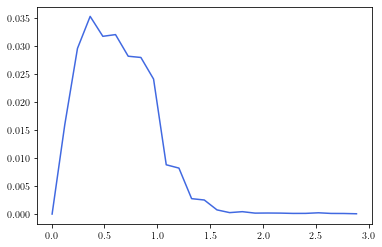

In [13]:
#Plot of modified source distribution (sized to fit model, for 25 points)
plt.plot(zsbin[:300][::12], (np.sum(nzs_weighted, axis=0)[:300][::12]/(np.trapz(np.sum(nzs, axis=0)[:300][::12]))), color='royalblue', label='Modified Source Redshift Distribution')
#Test that this distribution is properly normalized:
print(np.trapz(np.sum(nzs_weighted, axis=0)[:300][::12]/(np.trapz(np.sum(nzs_weighted, axis=0)[:300][::12]))))
#Yes, this distribution is normalized
#Question- this looks like a much higher peak than the full normalized distribution. I think it's because with fewer points it's weighted more strongly towards the lower redshifts.

In [14]:
#Defining parameters
zl = 13.2e-3 #lens redshift from posterior of MCMC
zl_sigma = 0.01 #width of lens redshift distribution
concentration = 2.
zs = z_mean_s  
theta_arcmin = np.geomspace(0.25, 1000, 25) #Scales for model
theta_rad = theta_arcmin/60*np.pi/180 #Change to radians
mass_term_1 = 1.7e11 #subhalo mass from checking chi2
mass_term_2 = 12.2e14 #host halo mass from posterior of MCMC
offset_rad = 14/60*np.pi/180 #Offset distance
da = Planck15.angular_diameter_distance(zl)

In [39]:
#Defining parameters for source redshift distribution model
zl_zsdist = 9.9e-3 #Lens redshift for source redshift distribution model from posterior of MCMC
mass_term_1_zsdist = 1.5e11 #Subhalo mass for source redshift distribution model, found by checking chi2
mass_term_2_zsdist = 16.9e14 #Host halo mass for source redshift distribution model from posterior of MCMC

In [40]:
#Source redshift distribution model
def total_model_zsdist(mass_term1, mass_term2, zs_mean, zl_mean, zl_sigma, theta_rad):
    zsrange = zsbin[:300][::12] #Range of source redshift distribution, must have 25 points 
    zsdist = np.sum(nzs_weighted, axis=0)[:300][::12] #Building up source redshift distribution
    A_zs = np.trapz(zsdist) #Normalization factor
    zsdist_norm = zsdist/A_zs #Normalized source redshift distribution
    
    zlrange = np.linspace(zl_mean - 1*zl_sigma, zl_mean + 3*zl_sigma, 25) #Lens redshift range
    zldist = stats.norm.pdf(zlrange, zl_mean, zl_sigma) #Gaussian lens redshift distribution
    A_zl = np.trapz(zldist) #Normalization factor for lens redshift
    zldist_norm = zldist/A_zl #Normalized lens redshift distribution 
    
    da = Planck15.angular_diameter_distance(zlrange) #Conversion from angular scales to physical scales based on redshift
    r_mpc = da*theta_rad
    nfw_term1 = NFW(mass_term1, concentration, zlrange) #Subhalo NFW
    print(nfw_term1)
    sigma_crit = nfw_term1.sigma_crit([zsrange]) #Sigma crit calculation
    esd = nfw_term1.projected_excess(r_mpc) #Excess surface density
    gt_term1 = esd/sigma_crit #Shear model for 25 NFW profiles
    I_calc_term1 = np.reshape((np.trapz(esd*zldist_norm)*np.trapz((1/sigma_crit)*(zsdist_norm))), (25,1)) #Integrated model over 25 NFW profiles, with normalized lens and source redshift distributions
    
    da_roff = Planck15.angular_diameter_distance(zl_mean) #Physical distance for offset
    mean_roff = np.array(offset_rad*da_roff) #Building offset distribution
    sigma_roff = np.sqrt(mean_roff)
    r_off_range = np.linspace(0, mean_roff+2*sigma_roff, 25)
    r_off_dist = stats.norm.pdf(r_off_range, mean_roff, sigma_roff)
    A_off = np.trapz(r_off_dist)
    A_off_norm = r_off_dist/A_off #Normalized offset distribution
    nfw_term2 = NFW(mass_term2, concentration, zlrange) #Host halo NFW
    print(nfw_term2)
    sigma_crit_term2 = nfw_term2.sigma_crit([zsrange]) #Host halo sigma crit
    esd_off_dist = nfw_term2.offset_projected_excess(np.array(r_mpc), np.array(r_off_dist)) #Excess surface density for offset NFW
    gt_term2 = esd_off_dist[0]/sigma_crit_term2 #Shear model for 25 NFW profiles
    I_calc_term2 = np.reshape((np.trapz(esd_off_dist[0]*A_off_norm*zldist_norm)*np.trapz((1/sigma_crit_term2)*(zsdist_norm))), (25,1)) #Integrated model with offset over 25 NFW profiles, with normalized lens and source redshift distributions
    
    total_model = I_calc_term1 + I_calc_term2 #Total model
    return total_model, I_calc_term1, I_calc_term2


In [41]:
#Model for a fixed source redshift
def total_model_zsfix(mass_term1, mass_term2, zs_mean, zl_mean, zl_sigma, theta_rad):
    zlrange = np.linspace(zl_mean - 1*zl_sigma, zl_mean + 3*zl_sigma, 25) #Lens redshift range
    zldist = stats.norm.pdf(zlrange, zl_mean, zl_sigma) #Gaussian lens redshift distribution
    A_zl = np.trapz(zldist) #Normalization factor for lens redshift
    zldist_norm = zldist/A_zl #Normalized lens redshift distribution 
    
    da = Planck15.angular_diameter_distance(zlrange) #Conversion from angular scales to physical scales based on redshift
    r_mpc = da*theta_rad
    nfw_term1 = NFW(mass_term1, concentration, zlrange) #Subhalo NFW
    print(nfw_term1)
    sigma_crit = nfw_term1.sigma_crit([zs_mean]) #Sigma crit for a fixed source redshift
    esd = nfw_term1.projected_excess(r_mpc) #Excess surface density
    gt_term1 = esd/sigma_crit #Shear model for 25 NFW profiles
    I_calc_term1 = np.reshape((np.trapz(gt_term1*zldist_norm)), (25,1)) #Integrated model with only lens redshift distribution
   
    da_roff = Planck15.angular_diameter_distance(zl_mean) #Conversion of offset to physical distance
    mean_roff = np.array(offset_rad*da_roff) #Building offset distribution
    sigma_roff = np.sqrt(mean_roff)
    r_off_range = np.linspace(0, mean_roff+2*sigma_roff, 25)
    r_off_dist = stats.norm.pdf(r_off_range, mean_roff, sigma_roff)
    A_off = np.trapz(r_off_dist)
    A_off_norm = r_off_dist/A_off #Offset normalized distribution
    nfw_term2 = NFW(mass_term2, concentration, zlrange) #Host halo NFW
    print(nfw_term2)
    sigma_crit_term2 = nfw_term2.sigma_crit([zs_mean]) #Host halo NFW with fixed source redshift
    esd_off_dist = nfw_term2.offset_projected_excess(np.array(r_mpc), np.array(r_off_dist)) #Excess surface density with offset 
    gt_term2 = esd_off_dist[0]/sigma_crit_term2 #Shear model for 25 offset NFW profiles
    I_calc_term2 = np.reshape((np.trapz(gt_term2*A_off_norm*zldist_norm)), (25,1)) #Integrated model with offset and only lens redshift distribution
    
    total_model = I_calc_term1 + I_calc_term2 #Total model
    return total_model, I_calc_term1, I_calc_term2


In [42]:
#Calling function for source redshift distribution
total_model_dist = total_model_zsdist(mass_term_1_zsdist, mass_term_2_zsdist, zs, zl_zsdist, zl_sigma, theta_rad)

NFW profile object containing 25 profiles
shape: (25,)
  overdensity: 500c
  log10 mass/Msun = 11.18
  concentration = 2.00
  redshift range = -0.00-0.04
NFW profile object containing 25 profiles
shape: (25,)
  overdensity: 500c
  log10 mass/Msun = 15.23
  concentration = 2.00
  redshift range = -0.00-0.04


In [43]:
#Calling function for fixed source redshift
total_model_zs_single = total_model_zsfix(mass_term_1, mass_term_2, zs, zl, zl_sigma, theta_rad)

NFW profile object containing 25 profiles
shape: (25,)
  overdensity: 500c
  log10 mass/Msun = 11.23
  concentration = 2.00
  redshift range = 0.00-0.04
NFW profile object containing 25 profiles
shape: (25,)
  overdensity: 500c
  log10 mass/Msun = 15.09
  concentration = 2.00
  redshift range = 0.00-0.04


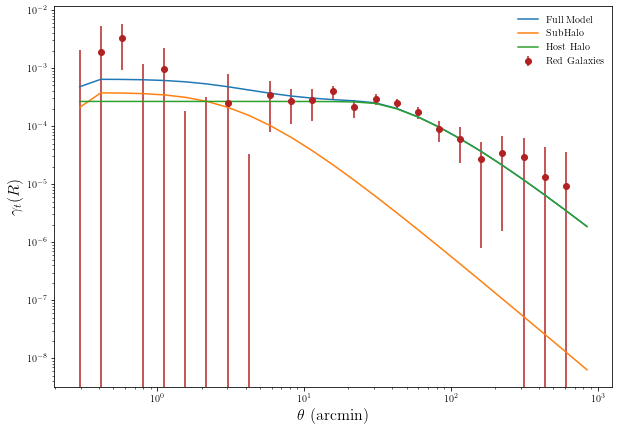

In [44]:
#Plot comparing measurements to source redshift distribution model
fig, ax = plt.subplots(figsize=(10,7), ncols=1)
plt.errorbar(theta_red, xi_red, err_jk_red, fmt="o", color="firebrick", label="Red Galaxies")
ax.plot(theta, total_model_dist[0], label = 'Full Model')
ax.plot(theta, total_model_dist[1], label = 'SubHalo')
ax.plot(theta, total_model_dist[2], label = 'Host Halo')
ax.set_ylabel(r'$\gamma_t(R)$', fontsize=16)
ax.set_xlabel('$\\theta$ (arcmin)', fontsize=16)
ax.legend(frameon=False)
ax.set_xscale('log')
ax.set_yscale('log')


In [45]:
#Chi2 calculation for source redshift distribution model
chi2_total = chi2(cov, total_model_dist[0], np.reshape(xi_red, (25,1)))
print(chi2_total)

[[35.97009553]]


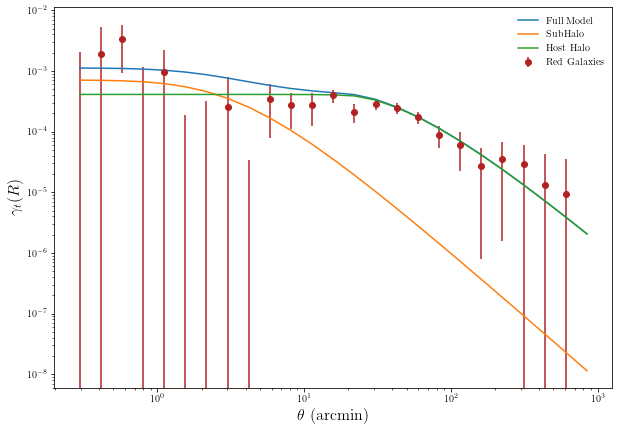

In [46]:
#Plot for fixed source redshift model
fig, ax = plt.subplots(figsize=(10,7), ncols=1)
plt.errorbar(theta_red, xi_red, err_jk_red, fmt="o", color="firebrick", label="Red Galaxies")
ax.plot(theta, total_model_zs_single[0], label = 'Full Model')
ax.plot(theta, total_model_zs_single[1], label = 'SubHalo')
ax.plot(theta, total_model_zs_single[2], label = 'Host Halo')
ax.set_ylabel(r'$\gamma_t(R)$', fontsize=16)
ax.set_xlabel('$\\theta$ (arcmin)', fontsize=16)
ax.legend(frameon=False)
ax.set_xscale('log')
ax.set_yscale('log')


In [47]:
#Chi2 for fixed source redshift model
chi2_total_zsfix = chi2(cov, total_model_zs_single[0], np.reshape(xi_red, (25,1)))
print(chi2_total_zsfix)

[[131.19894589]]


In [48]:
#Deltachi2 between fixed source redshift and source redshift distribution models
delta_dist = deltachi2(err_jk_red, total_model_zs_single[0], total_model_dist[0])
print(delta_dist)

[[14.44424199]]


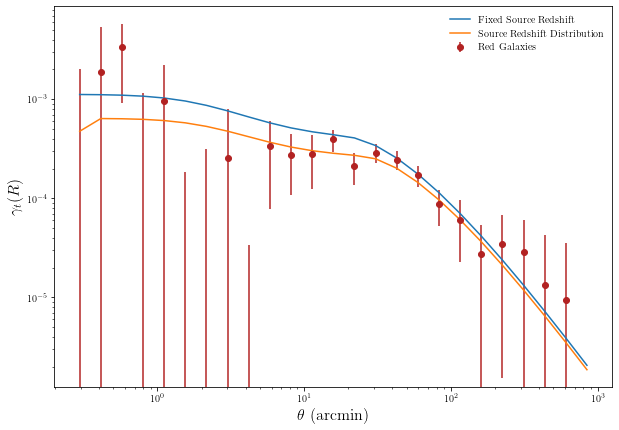

In [49]:
#Overlaid plot between fixed source redshift and source redshift distribution models
fig, ax = plt.subplots(figsize=(10,7), ncols=1)
plt.errorbar(theta_red, xi_red, err_jk_red, fmt="o", color="firebrick", label="Red Galaxies")
ax.plot(theta, total_model_zs_single[0], label = 'Fixed Source Redshift')
ax.plot(theta, total_model_dist[0], label = 'Source Redshift Distribution')
ax.set_ylabel(r'$\gamma_t(R)$', fontsize=16)
ax.set_xlabel('$\\theta$ (arcmin)', fontsize=16)
ax.legend(frameon=False)
ax.set_xscale('log')
ax.set_yscale('log')
